# Newton's Method for HIV Data in Table 14.2 of Lange

We start by visualizing the data and the contours.

In [31]:
import numpy as np
quarter = np.arange(14) + 1
deaths = np.array([0,1,2,3,1,4,9,18,23,31,20,25,37,45])

In [32]:
quarter

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [33]:
deaths

array([ 0,  1,  2,  3,  1,  4,  9, 18, 23, 31, 20, 25, 37, 45])

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

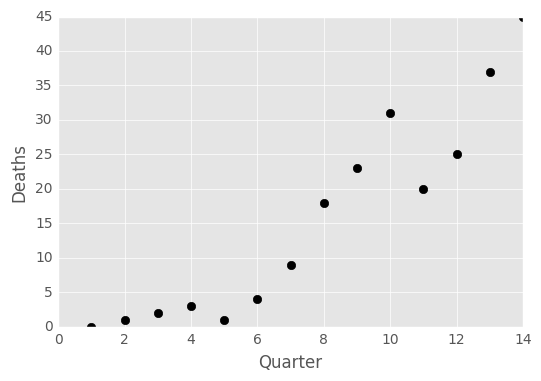

In [35]:
plt.plot(quarter, deaths, 'o', color='black');
plt.xlabel("Quarter");
plt.ylabel("Deaths");

Since `quarter` is the predictor and `deaths` is the response, we relabel these variables as x and y to make this a little more standard. 

In [36]:
x = quarter
y = deaths

"True" values are just what algorithm converged to in Table 14.3 of Lange.

In [37]:
theta1t, theta2t = 0.3396, 0.2565

## Newton's Method

The model we fit is
$$Y_i \sim Poisson(\mu(X_i))$$
where
$$\mu(x_i) = e^{\theta_1 + \theta_2x_i}$$
The log likelihood is
$$ L = \sum_{i=1}^n \left(-e^{\theta_1 + \theta_2x_i} + (\theta_1 + \theta_2x_i)y_i - \log y_i !\right)$$
We code the log likelihood and plot the contours.

In [38]:
## we ignore the -log(y!) in the loglik because it does not depend on theta
def loglike(theta1,theta2,x,y):
    s = -np.exp(theta1 + x*theta2)
    return np.sum(s + (theta1 + theta2*x)*y)

In [39]:
## see https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
## on meshgrid function for producing grid as input for contour plot
theta1g = np.linspace(0.0,1.0,100)
theta2g = np.linspace(0.2,0.3,100)

In [40]:
theta1g, theta2g = np.meshgrid(theta1g, theta2g)

In [41]:
XYpairs = np.vstack([ theta1g.reshape(-1), theta2g.reshape(-1) ])
Z = np.apply_along_axis(lambda z: loglike(z[0],z[1],x,y),0,XYpairs)
Z = Z.reshape((100,100))

We draw contour and 3-D plots of the log likelihood.

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


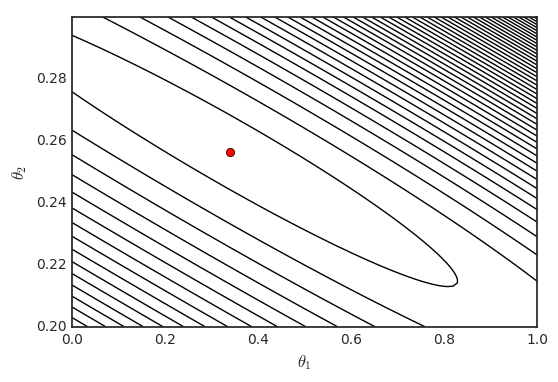

In [61]:
### PLOT 1: contours
plt.style.use('seaborn-white')
plt.contour(theta1g, theta2g, Z,50, colors='black');
plt.plot(theta1t,theta2t,'o',color='red');
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');


In [62]:
## 3-d plot based on code here: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


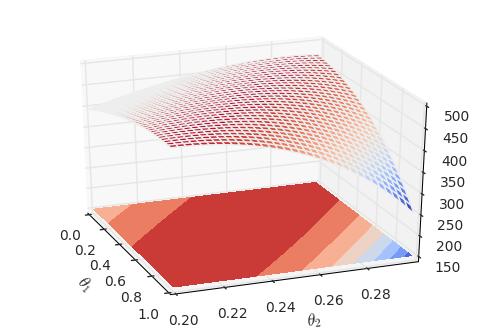

In [74]:

### PLOT 2: 3-D
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(theta1g, theta2g, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.coolwarm)

cset = ax.contourf(theta1g, theta2g, Z, zdir='z', offset=150, cmap=cm.coolwarm)

ax.set_zlim(145,500)
##ax.set_zticks(np.linspace(0,0.2))

# Adjust the limits, ticks and view angle
##ax.set_zlim(-0.15,0.2)
##ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');

plt.show()

## Gradient and Hessian Functions

We use Newton's method with step halving to maximize the log likelihood $L$. The gradient is
$$ dL = \left(\sum -e^{\theta_1 + \theta_2x_i} + y_i,\sum - x_i e^{\theta_1 + \theta_2} + x_iy_i\right)$$
and the Hessian is
$$d^2L = \begin{pmatrix}
\sum -e^{\theta_1 + \theta_2x_i} & \sum -x_i e^{\theta_1 + \theta_2x_i}\\
\sum -x_i e^{\theta_1 + \theta_2x_i} & \sum -x_i^2 e^{\theta_1 + \theta_2x_i}\\
\end{pmatrix}$$
The Hessian can be show to be negative definite for any parameters $\theta_1$ and $\theta_2$. Therefore to ensure that Newton's method goes uphill we only need to do step halving.

Further examination of $dL$ and $d^2L$ reveals that the following pseudocode can be used to compute the gradient and the Hessian. Define
$$s_i = -e^{\theta_1 + \theta_2x_i}$$
Then
$$dL = (sum(s + y),sum(sx + sy))$$
and
$$d^2L = \begin{pmatrix}
sum(s)& sum(sx)\\
sum(sx) & sum(sx^2)\\
\end{pmatrix}$$


In [13]:
def dloglike(theta1,theta2,x,y):
    s = -np.exp(theta1 + x*theta2)
    return np.array([np.sum(s + y),np.sum(x*s + x*y)])

def d2loglike(theta1,theta2,x,y):
    s = -np.exp(theta1 + x*theta2)
    cross = np.sum(s*x)
    return np.array([np.sum(s),cross,cross,np.sum(s*np.power(x,2))]).reshape(2,2)

Now run Newton with step halving. This is much like the logistic regression code with gradient ascent.

In [14]:
## initial values
theta1c = 0
theta2c = 0
Niter = 10
for jj in np.arange(Niter):
    print("theta1: " + str(theta1c) + " theta2: " + str(theta2c))
    g = dloglike(theta1c,theta2c,x,y).reshape((2,1))
    h = d2loglike(theta1c,theta2c,x,y)
    a,b = np.matmul(np.linalg.inv(h),g)
    c = 1.0
    half = True
    while half:
        t1 = theta1c - c*a
        t2 = theta2c - c*b
        if loglike(t1,t2,x,y) < loglike(theta1c,theta2c,x,y):
            print("halved")
            c = c / 2.0
        else:
            theta1c = t1
            theta2c = t2
            half = False

theta1: 0 theta2: 0
halved
halved
halved
theta1: [-1.30769231] theta2: [0.41840659]
theta1: [0.64560322] theta2: [0.24013801]
theta1: [0.37437854] theta2: [0.25415247]
theta1: [0.34003443] theta2: [0.25649294]
theta1: [0.33963397] theta2: [0.25652359]
theta1: [0.33963392] theta2: [0.25652359]
theta1: [0.33963392] theta2: [0.25652359]
halved
halved
halved
halved
halved
theta1: [0.33963392] theta2: [0.25652359]
halved
halved
halved
halved
halved
theta1: [0.33963392] theta2: [0.25652359]
halved
halved
halved
halved
halved


The algorithm converged in a small number of steps. The small changes in parameter values and the large number of step halving in later iterations tells us this.

** Exercise: ** Rewrite the above code to terminate after converence, rather than specifying a specific number of iterations. See Section 5.7 of Lange for some discussion of various convergence criteria.

In [15]:
V = np.linalg.inv(-h)
V

array([[ 0.06309492, -0.00533186],
       [-0.00533186,  0.00048572]])

In [16]:
np.sqrt(V[0,0])

0.2511870162238916

In [17]:
np.sqrt(V[1,1])

0.022039113258498184

## Numerically Approximating Hessians and Gradients

One can check the coded Hessians are correct by numerically approximating the Hessian using only the log likelihood function. For python these numerical differentiation tools are available in `numdifftools` package. R has similar tools, e.g. the package `numDeriv` available [here](https://cran.r-project.org/web/packages/numDeriv/numDeriv.pdf).

These tools are also useful for likelihoods where analytic gradients and Hessians are not available.

In [18]:
import numdifftools as nd

In [19]:
def loglike_wrap(thetas):
    return loglike(thetas[0],thetas[1],x,y)

In [20]:
out = nd.Hessian(loglike_wrap)([theta1c[0],theta2c[0]])

In [21]:
V_approx = np.linalg.inv(-out)

In [22]:
V

array([[ 0.06309492, -0.00533186],
       [-0.00533186,  0.00048572]])

In [23]:
V_approx

array([[ 0.06309492, -0.00533186],
       [-0.00533186,  0.00048572]])

In [24]:
V[0,0]

0.0630949171194616

In [26]:
V_approx[0,0]

0.06309491711952274

One could numerically approximate the Hessian and gradient at every step of Newton's method. The two disadvantages are that the approximation may not be accurate (although the above approximation looked pretty good) and the speed may be slower. We compare the time it takes to numerically approximate a Hessian to the time it takes to compute it analytically now.

In [28]:
%timeit out = nd.Hessian(loglike_wrap)([theta1c[0],theta2c[0]])

100 loops, best of 3: 4.33 ms per loop


In [29]:
%timeit d2loglike(theta1c[0],theta2c[0],x,y)

The slowest run took 7.25 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 18.5 µs per loop


** Exercise: ** Code Newton's method with numerically approximated gradients and Hessians and compare the speed of this new version to the version presented here with analytic gradients and Hessians.

** Exercise: ** Write a function `Newton` which takes arguments f, df, and d2f (function to optimize, gradient, and hessian) as well as data X and returns the maximizer. The function could also take as arguments number of iterations. You could make the df and d2f arguments optional and numerically approximate them if they are missing.